# Analysis of spiking model
## Read in data generated by Julia code

#### Taku Ito
#### 07/16/2019

In [44]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve2d
%matplotlib inline
import numpy.matlib as matlib
from statsmodels.distributions.empirical_distribution import ECDF
import time as timepkg
import h5py
import scipy.stats as stats
import pandas as pd

In [45]:
def bindata(trialdata,binSize,shiftSize):
    tLength = trialdata.shape[0]
    dim = data.ndim
    
    downSampledData = []
    i = 0 
    while i < (tLength-binSize):
        downSampledData.append(np.sum(trialdata[i:(i+binSize)],axis=0))
        i += shiftSize

    return np.asarray(downSampledData)

#### Load in data

In [184]:
binsize=50
shiftsize=10
dt = .1
T = 2000
ntrials = 30

df = {}
df['Stimulation'] = []
df['Variability'] = []
df['Spike rate'] = []

data = np.zeros((ntrials,T,4000))

fr = []
fr_mean = []
var_mean = []

# stimamprange = np.arange(-.1,0.11,.01)
# stimamprange = np.arange(-0.5,0.71,.02)
stimamprange = np.arange(-0.5,0.55,.05)


for stim in stimamprange:
    fr = []
    
    if np.round(stim,2)==0.0:
        stim = 0.0
    else:
        stim = np.round(stim,2)
    
    for i in np.arange(ntrials):

        outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(stim) + "_trial" + str(i+1) + ".h5"
        h5f = h5py.File(outputfilename,'r')
        Ne = h5f['Ne'][()] # Return scalar
#         Ncells = h5f['Ncells'][()] # Return scalar
#         times_spont = h5f['times'][:]
#         ns_spont = h5f['ns'][:]
#         T = h5f['T'][()] # Return scalar
        spikes = h5f['spikes'][:]
        h5f.close()

#         data[i,:] = np.mean(spikes[:Ne,:],axis=0)
        data[i,:,:] = spikes[:,:Ne]

        fr.append(bindata(data[i,:,:],binsize,shiftsize))

    fr = np.asarray(fr)
    
    
#     fr_mean.append(np.mean(np.mean(np.sum(fr,axis=2),0)))
#     var_mean.append(np.mean(np.var(np.sum(fr,axis=2),0)))
    
#     df['Variability'].extend(np.var(np.sum(fr,axis=2),0))
#     df['Stimulation'].extend(np.repeat(stim,fr.shape[1]))
#     df['Spike rate'].extend(np.mean(np.sum(fr,axis=2),0))
    
    fr_mean.append(np.mean(np.mean(fr,0)))
    var_mean.append(np.mean(np.var(fr,0)))
    
    df['Variability'].extend(np.mean(np.var(fr,0),axis=1))
    df['Stimulation'].extend(np.repeat(stim,fr.shape[1]))
    df['Spike rate'].extend(np.mean(np.mean(fr,axis=0),1))



#     # # Task versus rest
#     t_fr, p_fr = stats.ttest_rel(np.mean(fr_stm,0),np.mean(fr_iti,0))
#     t_var, p_var = stats.ttest_rel(np.var(fr_stm,0),np.var(fr_iti,0))
#     print("Task versus rest, firing rate:", t_fr, p_fr)
#     print("Task versus rest, variability:", t_var, p_var)


Text(0, 0.5, 'Variability')

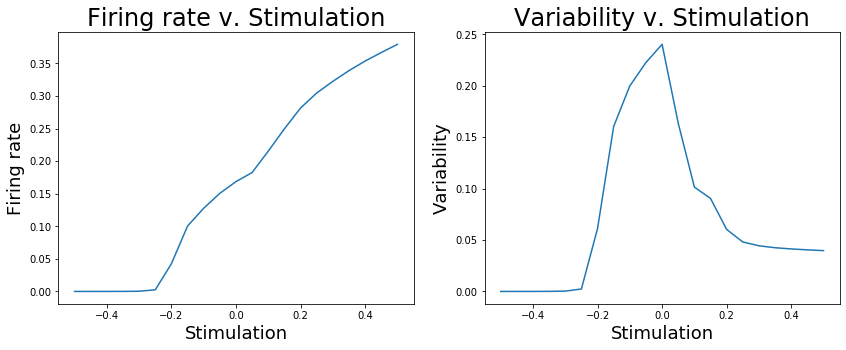

In [185]:
# start = 5
# stop = 40
start = 0
stop = len(stimamprange)
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(stimamprange[start:stop],fr_mean[start:stop])
plt.title("Firing rate v. Stimulation", fontsize=24)
plt.xlabel('Stimulation',fontsize=18)
plt.ylabel('Firing rate',fontsize=18)

plt.subplot(122)
plt.plot(stimamprange[start:stop],var_mean[start:stop])
plt.title("Variability v. Stimulation", fontsize=24)
plt.xlabel('Stimulation',fontsize=18)
plt.ylabel('Variability',fontsize=18)

#### Correlate magnitude of stimulation with variability

In [235]:
stats.spearmanr(var_mean,np.abs(stimamprange))

SpearmanrResult(correlation=-0.9155844155844156, pvalue=5.944567669407678e-09)

In [236]:
stats.spearmanr(fr_mean,np.abs(stimamprange))

SpearmanrResult(correlation=-0.07142857142857142, pvalue=0.758328345457485)

# normalize data

In [240]:
df['Spike rate'][:] = (df['Spike rate'][:] - np.min(df['Spike rate'][:]))/(np.max(df['Spike rate']) - np.min(df['Spike rate'][:]))

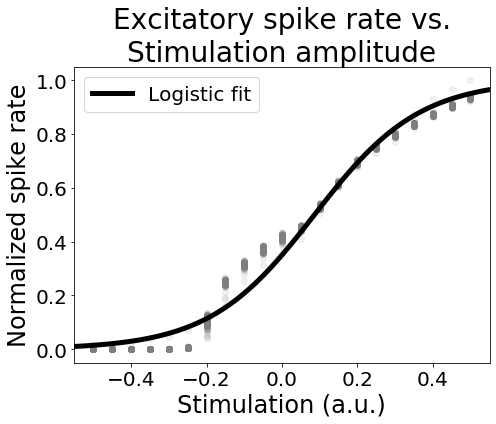

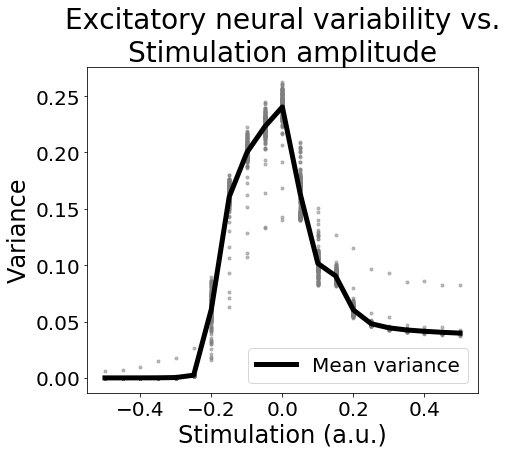

In [244]:
df = pd.DataFrame(df)
plt.figure(figsize=(7,6))
sns.regplot(x="Stimulation",y="Spike rate",logistic=True,fit_reg=True,data=df,marker='o',line_kws={'color':'k','linewidth':5.0,'label':'Logistic fit'},scatter_kws={'alpha':0.1,'color':'C7'})
plt.ylabel('Normalized spike rate', fontsize=24)
plt.xlabel('Stimulation (a.u.)',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Excitatory spike rate vs.\nStimulation amplitude', fontsize=28)
plt.legend(prop={'size': 20})
plt.tight_layout()
plt.savefig('SpikingModel_SigmoidEstimation.png',dpi=150)

plt.figure(figsize=(7,6))
sns.regplot(x="Stimulation",y="Variability",logistic=False,fit_reg=False,data=df,marker='.',scatter_kws={'alpha':0.5,'color':'C7'})
plt.plot(stimamprange[:],var_mean[:],color='k',linewidth=5,label='Mean variance')
plt.ylabel('Variance', fontsize=24)
plt.xlabel('Stimulation (a.u.)',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Excitatory neural variability vs.\nStimulation amplitude', fontsize=28)
plt.legend(prop={'size': 20})
plt.savefig('SpikingModel_SpikingVariability.png',dpi=150)


___

# Plot raster plots at min, 0, and max stimulation amplitudes

#### Raster plot for minimum stimulation amplitude

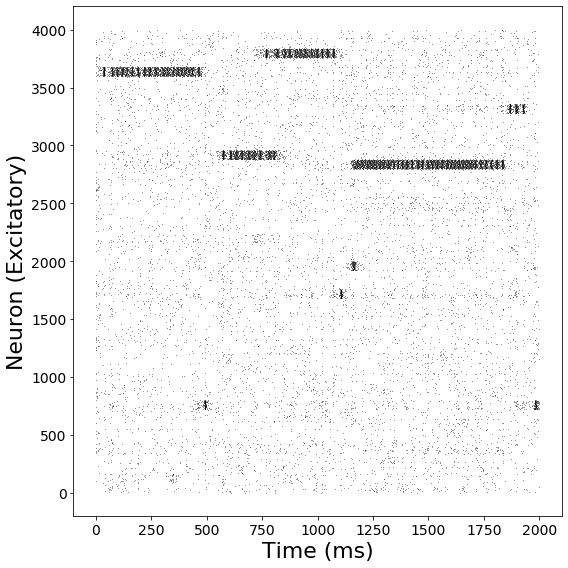

In [197]:
minval = np.round(stimamprange[0],1)
outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(minval) + "_trial" + str(i+1) + ".h5"
outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(-0.15) + "_trial" + str(i+1) + ".h5"
h5f = h5py.File(outputfilename,'r')
Ne = h5f['Ne'][()] # Return scalar
# Ncells = h5f['Ncells'][()] # Return scalar
times_spont = h5f['times'][:].T
ns = h5f['ns'][:]
# T = h5f['T'][()] # Return scalar
# spikes = h5f['spikes'][:]
h5f.close()
plt.figure(figsize=(8,8))
for ci in range(Ne):
    vals = times_spont[ci,0:ns[ci]]
    y = ci*np.ones((len(vals),))
    plt.scatter(vals,y,s=.3,c="k",marker="o",linewidths=0)

plt.ylabel("Neuron (Excitatory)",fontsize=22)
plt.xlabel("Time (ms)",fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("RasterPlot_MinStim.png",dpi=150)

#### Raster plot for 0 stimulation amplitude

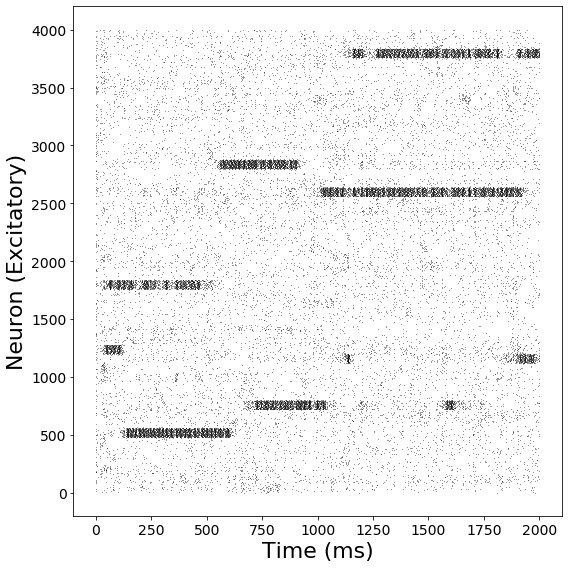

In [196]:
minval = np.round(stimamprange[0],1)
outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(0.0) + "_trial" + str(9) + ".h5"
h5f = h5py.File(outputfilename,'r')
Ne = h5f['Ne'][()] # Return scalar
# Ncells = h5f['Ncells'][()] # Return scalar
times_spont = h5f['times'][:].T
ns = h5f['ns'][:]
# T = h5f['T'][()] # Return scalar
# spikes = h5f['spikes'][:]
h5f.close()
plt.figure(figsize=(8,8))
for ci in range(Ne):
    vals = times_spont[ci,0:ns[ci]]
    y = ci*np.ones((len(vals),))
    plt.scatter(vals,y,s=.3,c="k",marker="o",linewidths=0)

plt.ylabel("Neuron (Excitatory)",fontsize=22)
plt.xlabel("Time (ms)",fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("RasterPlot_0Stim.png",dpi=150)

#### Raster plot for maximum stimulation amplitude

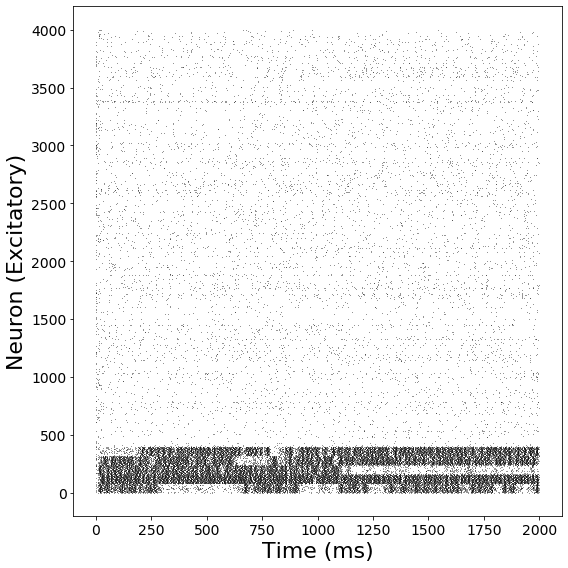

In [198]:
maxval = np.round(stimamprange[-1],1)
outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(maxval) + "_trial" + str(i+1) + ".h5"
outputfilename = "/projects3/TaskFCMech/data/results/spikingModel/balanced_simoutput_stim" + str(0.15) + "_trial" + str(i+1) + ".h5"
h5f = h5py.File(outputfilename,'r')
Ne = h5f['Ne'][()] # Return scalar
# Ncells = h5f['Ncells'][()] # Return scalar
times_spont = h5f['times'][:].T
ns = h5f['ns'][:]
# T = h5f['T'][()] # Return scalar
# spikes = h5f['spikes'][:]
h5f.close()
plt.figure(figsize=(8,8))
for ci in range(Ne):
    vals = times_spont[ci,0:ns[ci]]
    y = ci*np.ones((len(vals),))
    plt.scatter(vals,y,s=.3,c="k",marker="o",linewidths=0)

plt.ylabel("Neuron (Excitatory)",fontsize=22)
plt.xlabel("Time (ms)",fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("RasterPlot_MaxStim.png",dpi=150)